In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from scipy.stats import chi2_contingency
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

## Importing Dataset

In [2]:
df=pd.read_csv('/Users/deogirekartik/Vscode/Technical Seminar/datset/healthcare-dataset-stroke34-data.csv')

In [3]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [4]:
# Droping ID 
df.drop(['id'], axis = 1, inplace = True)

In [5]:
df.head(5) # Givs first observations

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
df.dtypes # Data Type of the features

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [7]:
df.describe # To describe the data

<bound method NDFrame.describe of       gender   age  hypertension  heart_disease ever_married      work_type  \
0       Male  67.0             0              1          Yes        Private   
1     Female  61.0             0              0          Yes  Self-employed   
2       Male  80.0             0              1          Yes        Private   
3     Female  49.0             0              0          Yes        Private   
4     Female  79.0             1              0          Yes  Self-employed   
...      ...   ...           ...            ...          ...            ...   
5105  Female  80.0             1              0          Yes        Private   
5106  Female  81.0             0              0          Yes  Self-employed   
5107  Female  35.0             0              0          Yes  Self-employed   
5108    Male  51.0             0              0          Yes        Private   
5109  Female  44.0             0              0          Yes       Govt_job   

     Residence_ty

In [8]:

df.shape #Number of Rows and Columns or Observations and Features

(5110, 11)

## DATA PREPROCESSING

## Dealing with Null Values

In [9]:
df.isna().sum() # Will give tatal number of null values in every column

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

BMI have 201 null values

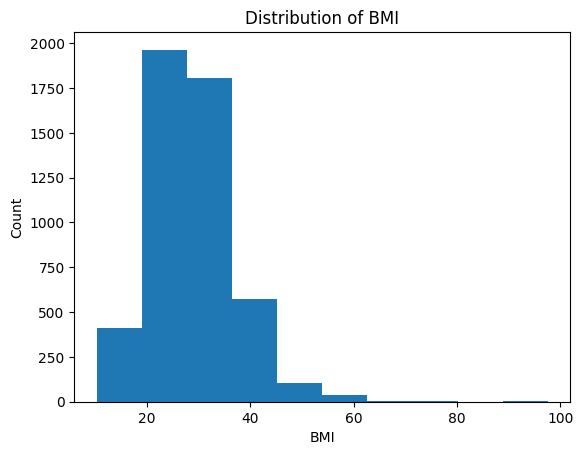

In [10]:
# To observe the distribution of BMI 
df['bmi'].plot.hist(bins=10)
plt.xlabel('BMI')
plt.ylabel('Count')
plt.title('Distribution of BMI')
plt.show()

In [11]:
df['bmi'] = df['bmi'].fillna(df['bmi'].median()) # Using meadian metjod tto fill the null values

In [12]:
df.isna().sum() # Re check

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

## Dealing with Duplicates

In [13]:
df.duplicated().sum() 

0

## Dealing with Outliers

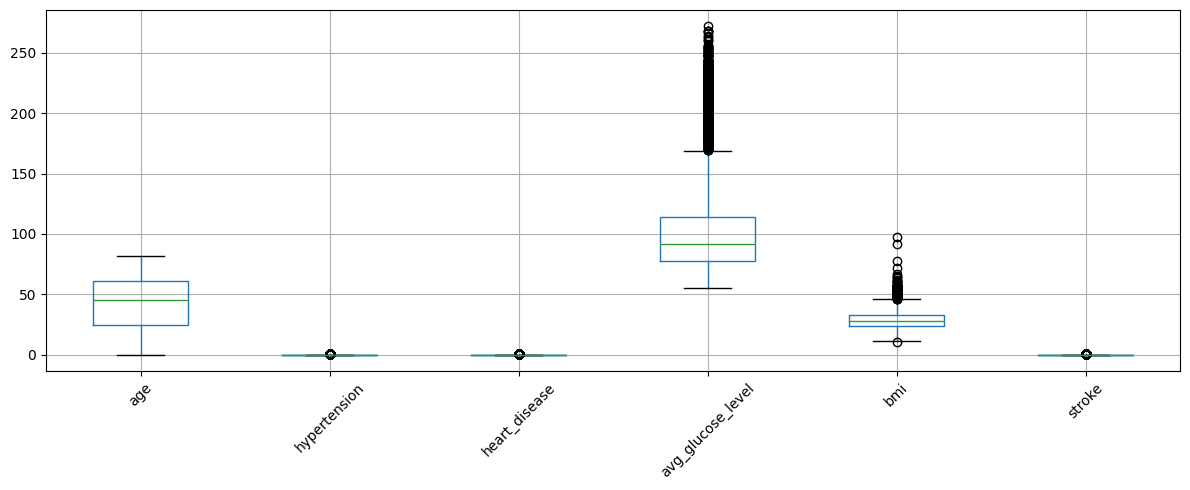

In [14]:
plt.figure(figsize=(12, 5))
df.boxplot(fontsize=10)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

Outliers can be seen in 'Average Glucose Level', 'BMI'

In [15]:
# Using IQR to to detect outliers
for var in ['avg_glucose_level', 'bmi']:
  percentile25 = df[var].quantile(0.25)
  percentile75 = df[var].quantile(0.75)
  iqr = percentile75 - percentile25
  upper_limit = percentile75 + 1.5 * iqr
  lower_limit = percentile25 - 1.5 * iqr
  outliers = df[(df[var] > upper_limit) | (df[var] < lower_limit)]

  # Counting how many rows in the data contain outliers in `tenure`
  print(F"Number of rows in the data containing outliers in {var}:", len(outliers))

Number of rows in the data containing outliers in avg_glucose_level: 627
Number of rows in the data containing outliers in bmi: 126


In [16]:
# Using IQR to to remove outliers
for col in ['avg_glucose_level', 'bmi']:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Number of rows after removing outliers
print(f"Number of rows after removing outliers: {df.shape[0]}")

Number of rows after removing outliers: 4383


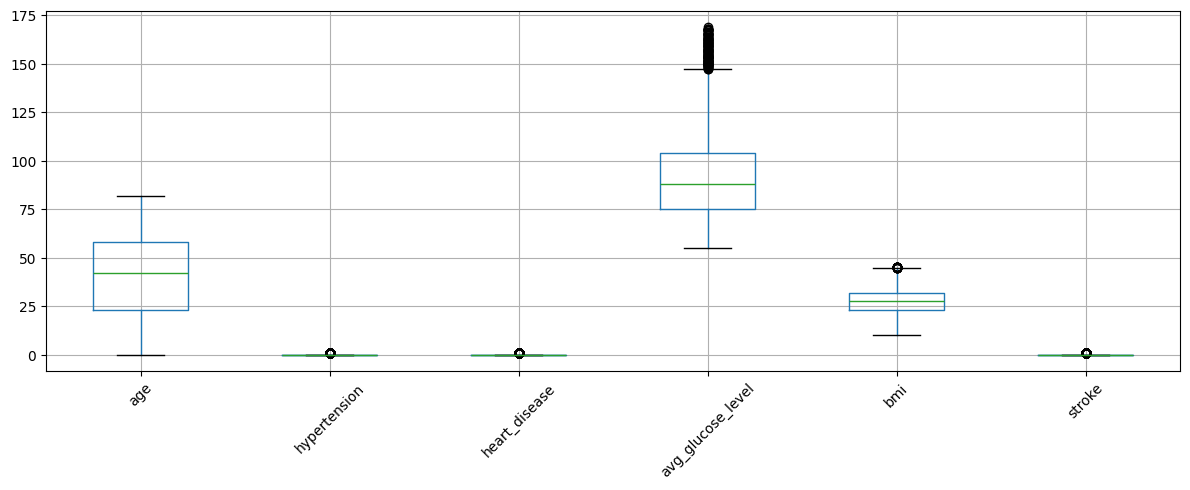

In [17]:
plt.figure(figsize=(12, 5))
df.boxplot(fontsize=10)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

In [18]:
df['stroke'] = df['stroke'].astype('category') # Make 0 as Unstroke and 1 as stroke

Numerical columns

In [19]:
# Unique value counts for each column
unique_counts = df.nunique()
# Threshold to distinguish continuous and categorical
threshold = 10

num_cols = unique_counts[unique_counts > threshold].index.tolist()

## Feature Transformation

In [20]:
def visualize_feature_distribution(data):
    data = data.apply(pd.to_numeric, errors='coerce')
    sns.set(style="whitegrid")
    num_features = len(data.columns)
    num_cols = 3  
    num_rows = -(-num_features // num_cols)  
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(data.columns):
        sns.histplot(data[column], kde=True, color="skyblue", bins=30, ax=axes[i])
        axes[i].set_title(f'Distribution of {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

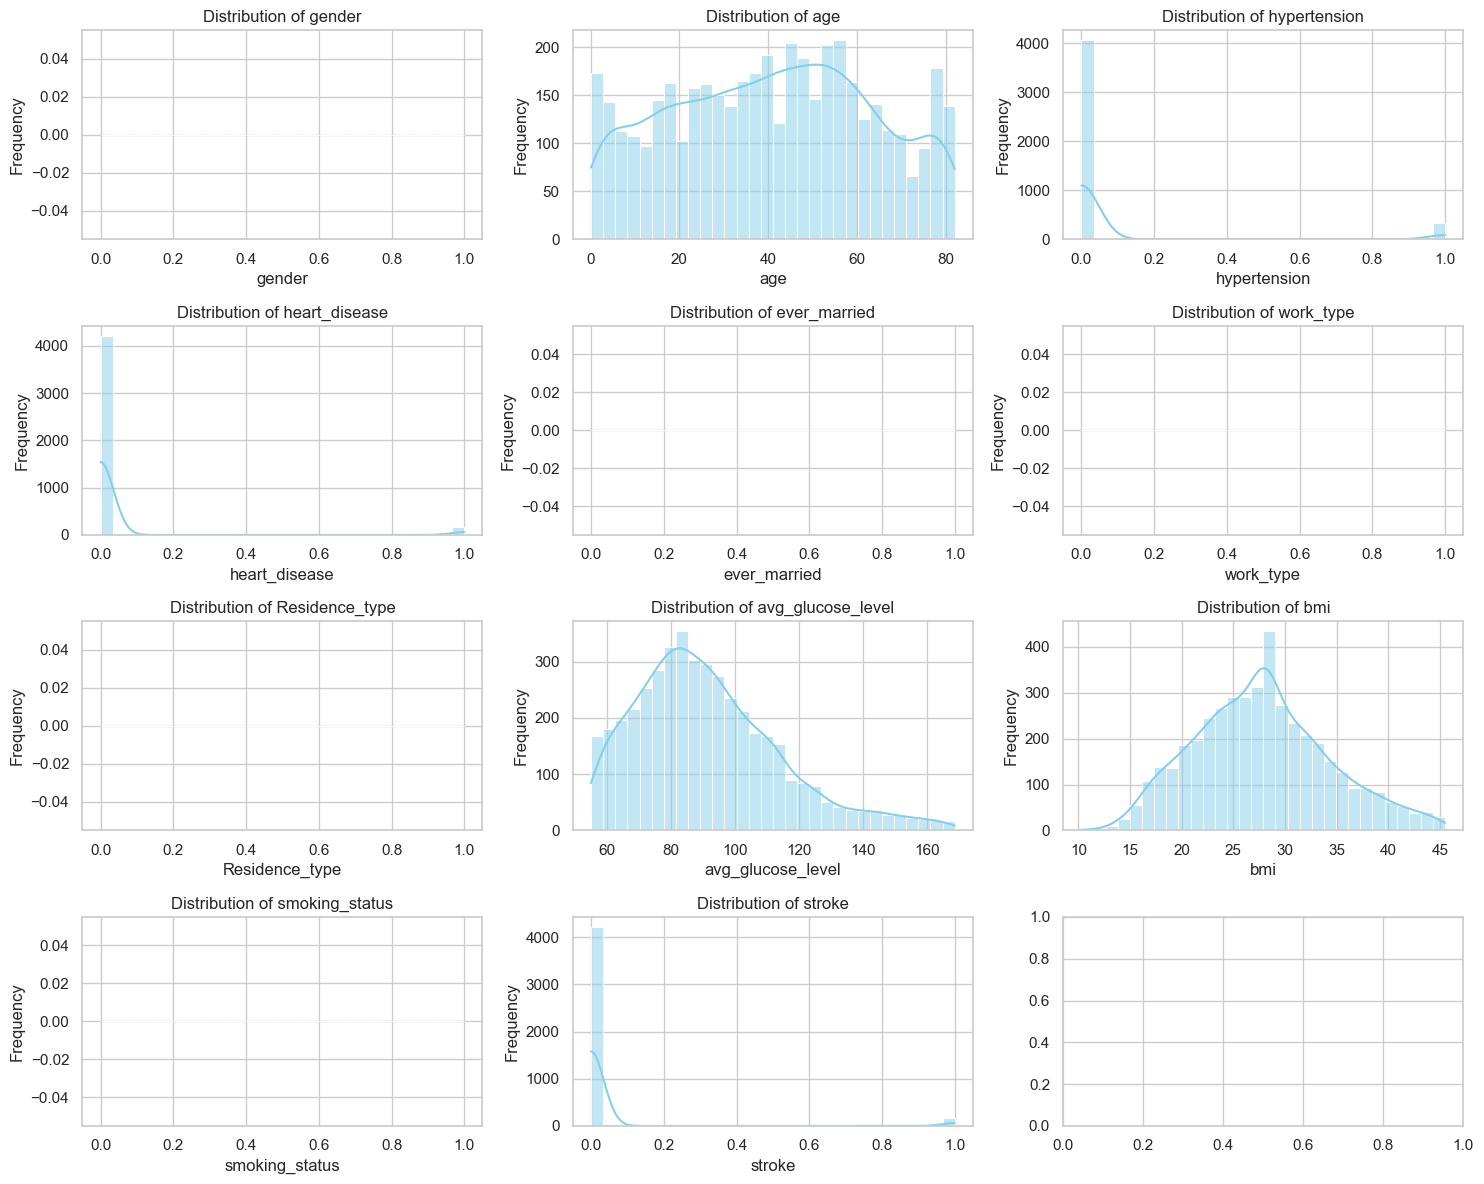

In [21]:
import warnings
warnings.filterwarnings('ignore')
visualize_feature_distribution(df)

In [22]:
df['avg_glucose_level'] = np.log1p(df['avg_glucose_level'])

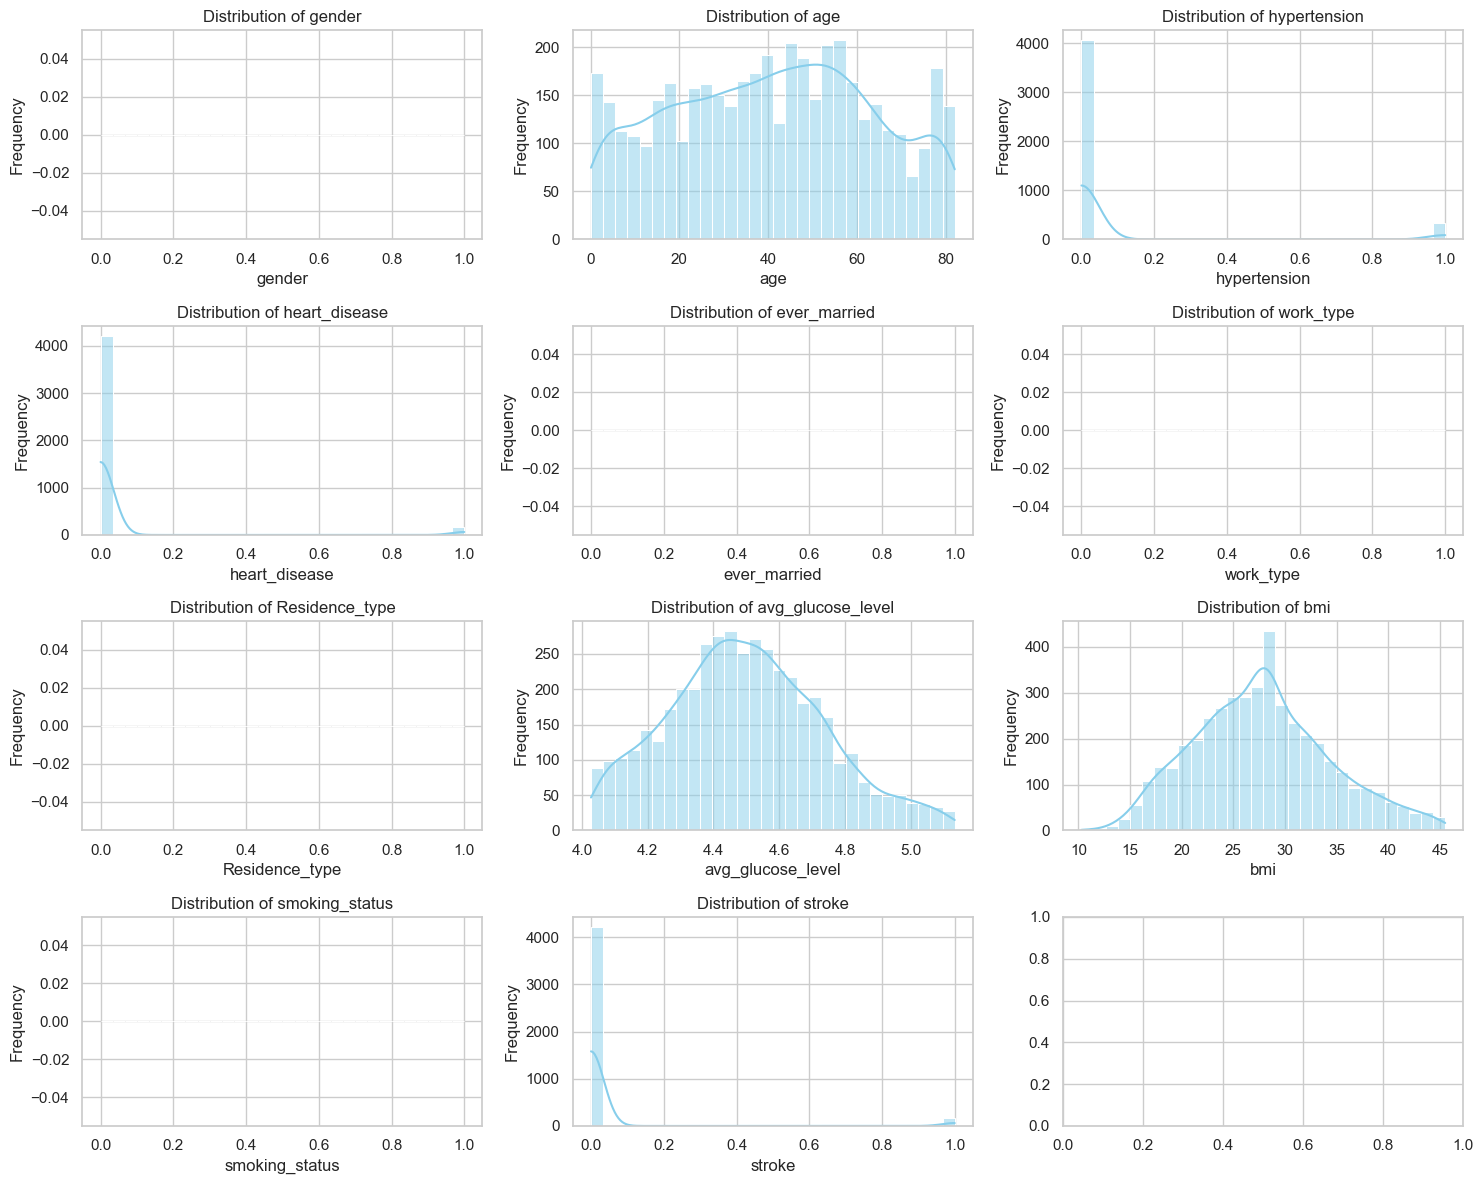

In [23]:
visualize_feature_distribution(df)

## Correlation

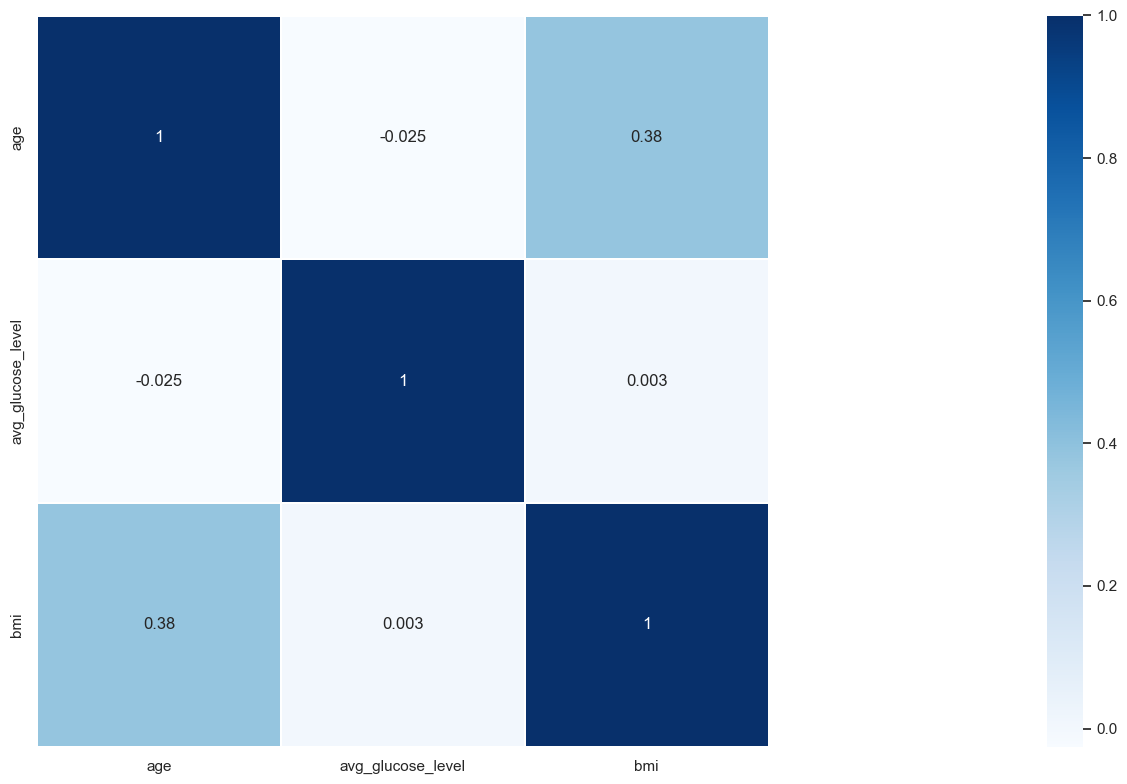

In [24]:
plt.figure(figsize=(56, 8))
corr = df.loc[:,num_cols].corr(method="pearson")
sns.heatmap(corr, cmap='Blues', square=True, linewidths=.2, annot = True)
plt.tight_layout()

## Feature Selection

## Chi Square test 

In [25]:
df['smoking_status'].unique()

array(['never smoked', 'Unknown', 'smokes', 'formerly smoked'],
      dtype=object)

In [26]:
frequency_distribution = df['smoking_status'].value_counts()
print("Frequency Distribution:\n", frequency_distribution)

Frequency Distribution:
 smoking_status
never smoked       1592
Unknown            1417
formerly smoked     707
smokes              667
Name: count, dtype: int64


In [27]:
contingency_table = pd.crosstab(df['smoking_status'], df['stroke'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("Chi-square statistic:", chi2)
print("P-value:", p)

Chi-square statistic: 24.519285406354893
P-value: 1.945970448972603e-05


Significant association between Smoking status and Stroke

In [28]:

df['work_type'].unique()

array(['Private', 'Govt_job', 'Self-employed', 'children', 'Never_worked'],
      dtype=object)

In [29]:
frequency_distribution = df['work_type'].value_counts()
print("Frequency Distribution:\n", frequency_distribution)

Frequency Distribution:
 work_type
Private          2476
children          675
Self-employed     659
Govt_job          551
Never_worked       22
Name: count, dtype: int64


In [30]:
contingency_table = pd.crosstab(df['work_type'], df['stroke'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("Chi-square statistic:", chi2)
print("P-value:", p)

Chi-square statistic: 46.06663706176117
P-value: 2.3854515743667498e-09


Significant association between Work type and Stroke

In [31]:
frequency_distribution = df['ever_married'].value_counts()
print("Frequency Distribution:\n", frequency_distribution)

Frequency Distribution:
 ever_married
Yes    2730
No     1653
Name: count, dtype: int64


In [32]:
contingency_table = pd.crosstab(df['ever_married'], df['stroke'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("Chi-square statistic:", chi2)
print("P-value:", p)

Chi-square statistic: 37.62054260180537
P-value: 8.593467720140566e-10


In [33]:
contingency_table = pd.crosstab(df['Residence_type'], df['stroke'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("Chi-square statistic:", chi2)
print("P-value:", p)

Chi-square statistic: 0.26712585273353606
P-value: 0.6052663234730102


Null hypothesis is accepted hence we can say that RT does not significant assciation with Stroke

In [34]:
# Droping Residence type from dataset
df.drop(['Residence_type'], axis = 1, inplace = True)

In [35]:
df.dtypes

gender                 object
age                   float64
hypertension            int64
heart_disease           int64
ever_married           object
work_type              object
avg_glucose_level     float64
bmi                   float64
smoking_status         object
stroke               category
dtype: object

## Threshold Variance

In [36]:
# For feature selection first we have split our data into train and test

from sklearn.model_selection import train_test_split

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10, test_size = 0.22)

In [37]:
X_numeric = X.apply(pd.to_numeric, errors='coerce')
feature_variances = X_numeric.var()
max_variance = feature_variances.max()
print("Maximum Variance Across Features:", max_variance)

Maximum Variance Across Features: 509.17956774538527


In [38]:
from sklearn.feature_selection import VarianceThreshold

X_numerical = X.select_dtypes(include='float64')
selector = VarianceThreshold(threshold=6)
X_selected = selector.fit_transform(X_numeric)

In [39]:
selected_features_indices = selector.get_support()
selected_feature_names = X.columns[selected_features_indices]

print("Selected Feature Names:", selected_feature_names)

Selected Feature Names: Index(['age', 'bmi'], dtype='object')


## Numerical and Categorical Columns

In [40]:
# Unique value counts for each column
unique_counts = df.nunique()
# Threshold to distinguish continuous and categorical
threshold = 10

num_cols = unique_counts[unique_counts > threshold].index.tolist()
cat_cols = unique_counts[unique_counts <= threshold].index.tolist()

# Removing the 'stroke' from categorical since it's our target variable
if 'stroke' in cat_cols:
    cat_cols.remove('stroke')

# Convert to category datatype
for col in cat_cols:
  df[col] = df[col].astype('category')

## Standardization

In [41]:
scaler = StandardScaler().set_output(transform='pandas')
df_num = df[num_cols].copy()
df_num = scaler.fit_transform(df_num)

In [42]:
df_cat = pd.get_dummies(df[cat_cols], drop_first=True)

In [43]:

X = pd.concat([df_num, df_cat], axis=1)
y = df[['stroke']].copy()

## Imbalanced Dataset

In [44]:
import pandas as pd


stroke_column = df['stroke']

# Count occurrences of 1's and 0's
count_ones = (stroke_column == 1).sum()
count_zeros = (stroke_column == 0).sum()

print("Number of 1's:", count_ones)
print("Number of 0's:", count_zeros)

Number of 1's: 164
Number of 0's: 4219


In [45]:
over = SMOTE(sampling_strategy = 1)
X_smote, y_smote = over.fit_resample(X, y)

In [46]:
y_smote.value_counts()

stroke
0         4219
1         4219
Name: count, dtype: int64

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.25, random_state=42)

In [48]:
def get_test_scores(model_name:str, preds, y_test_data, auc):
    table = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'F1 Score', 'Accuracy', 'AUC'])
    table.loc[0] = {
        'Model': model_name,
        'Precision': precision_score(y_test_data, preds),
        'Recall': recall_score(y_test_data, preds),
        'F1 Score': f1_score(y_test_data, preds),
        'Accuracy': accuracy_score(y_test_data, preds),
        'AUC': auc
    }
    return table

In [49]:
test_scores = []
target_names = ['No stroke', 'Stroke']
models = [
          GaussianNB(),
          RandomForestClassifier(),
          KNeighborsClassifier()
          ]
model_name_list = []
model_metrics = {}

for mdl in models:
    model = mdl.fit(X_train, y_train)
    model_name = model.__class__.__name__
    y_pred = model.predict(X_test)
    report  = classification_report(y_test, y_pred, target_names=target_names)

    # Calculate ROC and AUC
    probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    test_score = get_test_scores(model_name, y_pred, y_test, auc )

    model_metrics[model_name] = [model, y_pred, report, fpr, tpr, auc, test_score]

In [50]:
for key, value in model_metrics.items():
  print(f"Report for {key} model:")
  print(value[2])

Report for GaussianNB model:
              precision    recall  f1-score   support

   No stroke       0.96      0.35      0.51      1054
      Stroke       0.60      0.99      0.75      1056

    accuracy                           0.67      2110
   macro avg       0.78      0.67      0.63      2110
weighted avg       0.78      0.67      0.63      2110

Report for RandomForestClassifier model:
              precision    recall  f1-score   support

   No stroke       0.97      0.92      0.95      1054
      Stroke       0.92      0.98      0.95      1056

    accuracy                           0.95      2110
   macro avg       0.95      0.95      0.95      2110
weighted avg       0.95      0.95      0.95      2110

Report for KNeighborsClassifier model:
              precision    recall  f1-score   support

   No stroke       0.98      0.82      0.89      1054
      Stroke       0.85      0.98      0.91      1056

    accuracy                           0.90      2110
   macro avg       

In [51]:
scores_list = [model_metrics[x][6] for  x in model_metrics.keys()]
final_test_scores = pd.concat(scores_list)
final_test_scores.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)

,Model,Precision,Recall,F1 Score,Accuracy,AUC
0,RandomForestClassifier,0.923767,0.975379,0.948871,0.947393,0.989945
1,KNeighborsClassifier,0.846781,0.983902,0.910206,0.902844,0.951684
2,GaussianNB,0.603358,0.986742,0.748832,0.668720,0.834552


## Fine Tunning of Parameters to increase the accuracy of RF

In [52]:
param_grid = {
    'n_estimators': [300, 500,600],
    'max_depth': [3, 5, None],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the RandomForestClassifier
rfc = RandomForestClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(rfc, param_grid, cv=5,scoring='accuracy',verbose=1, n_jobs=7)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Print the best parameters
print("Best parameters:", best_params)

# Train the model with the best parameters
best_rfc = RandomForestClassifier(**best_params)
best_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklea

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


RandomForestClassifier(n_estimators=500)

In [57]:
# Evaluate the model on the test set
preds = best_rfc.predict(X_test)
evaluation_table = get_test_scores('rfc', preds,y_test, auc)

# Display the evaluation table
print(evaluation_table)

  Model  Precision    Recall  F1 Score  Accuracy       AUC
0   rfc   0.920536  0.976326   0.94761  0.945972  0.951684


In [58]:
import pickle

# Assuming `model` is your trained model object
with open('trained_model.pkl', 'wb') as f:
    pickle.dump(best_rfc, f)


In [55]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Define values of k to try
k_values = [1, 3, 5, 7, 8]

# Define number of folds for cross-validation
num_folds = 5

# Create k-fold cross-validation object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize lists to store average performance for each value of k
avg_scores = []

# Iterate over each value of k
for k in k_values:
    # Initialize k-NN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Perform cross-validation
    scores = cross_val_score(knn, X, y, cv=kf, scoring='accuracy')
    
    # Compute average performance
    avg_score = np.mean(scores)
    avg_scores.append(avg_score)

# Find the index of the best performing k
best_k_idx = np.argmax(avg_scores)
best_k = k_values[best_k_idx]
best_score = avg_scores[best_k_idx]

print("Best k:", best_k)
print("Average performance:", best_score)


Best k: 8
Average performance: 0.9621246674268338


ValueError: x and y must have same first dimension, but have shapes (7,) and (1,)

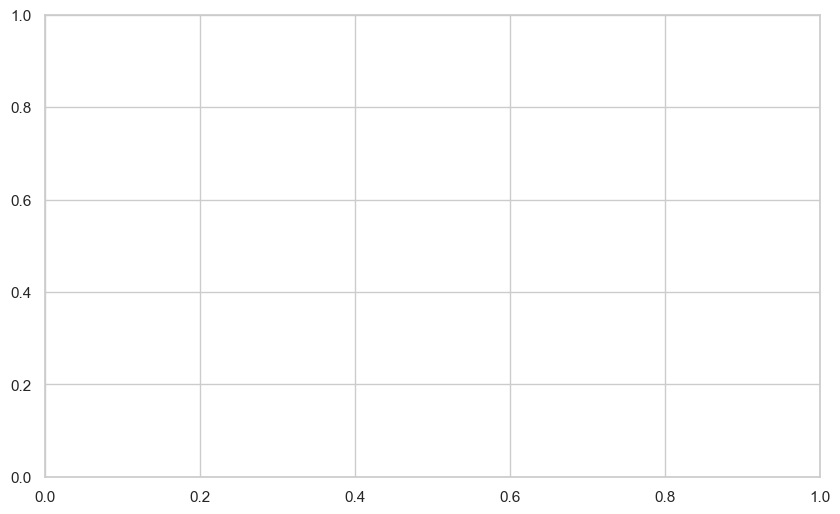

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier

# Define values of k to try
k_values = range(1, 8)  

# Define number of folds for cross-validation
num_folds = 5

# Create k-fold cross-validation object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize list to store average accuracy for each value of k
avg_accuracies = []

# Load your data into X and y
# Assuming you have loaded your data into X and y

# Iterate over each value of k
for k in k_values:
    # Initialize k-NN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Perform cross-validation
    accuracies = cross_val_score(knn, X, y, cv=kf, scoring='accuracy')
    
    # Compute average accuracy
    avg_accuracy = np.mean(accuracies)
k = avg_accuracies.append(avg_accuracy)


# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, avg_accuracies, marker='o', linestyle='-')
plt.title('Average Cross-Validation Accuracy vs. k')
plt.xlabel('k')
plt.ylabel('Average Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()


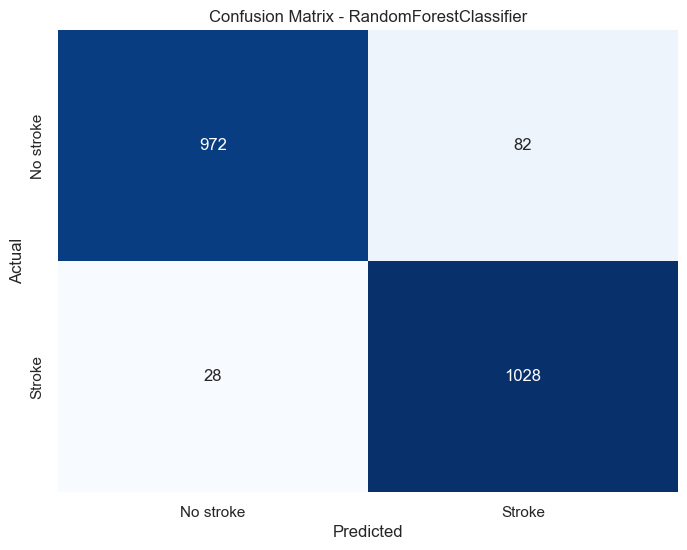

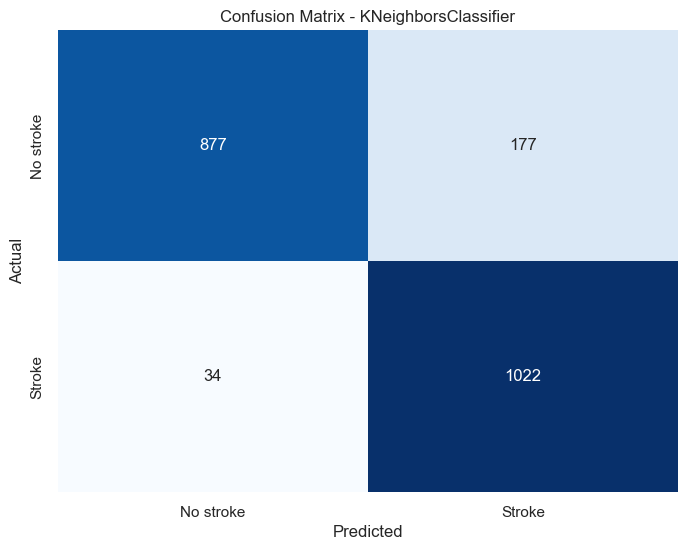

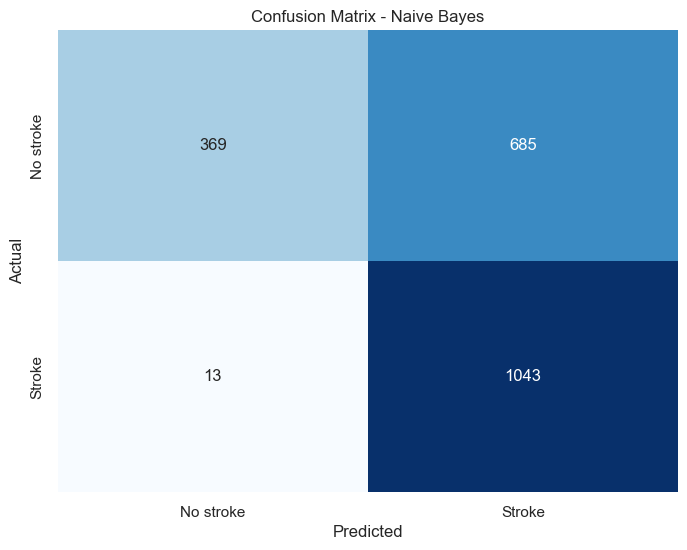

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to plot confusion matrix
def plot_confusion_matrix(model, X_test, y_test, model_name):
    # Predictions
    y_pred = model.predict(X_test)
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No stroke', 'Stroke'],
                yticklabels=['No stroke', 'Stroke'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Plot confusion matrix for RandomForestClassifier
plot_confusion_matrix(best_rfc, X_test, y_test, 'RandomForestClassifier')

# Plot confusion matrix for KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=best_k)  # Using the best k found
knn.fit(X_train, y_train)
plot_confusion_matrix(knn, X_test, y_test, 'KNeighborsClassifier')

# Plot confusion matrix for Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
plot_confusion_matrix(nb, X_test, y_test, 'Naive Bayes')


In [ ]:
# Access the first observation in the resampled dataset
first_observation_features = X_smote.iloc[0]
first_observation_target = y_smote.iloc[0]

# Print the first observation's features and target
print("First observation features:", first_observation_features)
print("First observation target:", first_observation_target)


First observation features: age                               1.733246
avg_glucose_level                 0.735149
bmi                               0.729592
gender_Male                           True
gender_Other                         False
hypertension_1                       False
heart_disease_1                       True
ever_married_Yes                      True
work_type_Never_worked               False
work_type_Private                     True
work_type_Self-employed              False
work_type_children                   False
smoking_status_formerly smoked       False
smoking_status_never smoked           True
smoking_status_smokes                False
Name: 0, dtype: object
First observation target: stroke    1
Name: 0, dtype: category
Categories (2, int64): [0, 1]


## Prediciton using RF

In [ ]:
def predict_stroke_rf(model, feature_data):
    # Take user input for feature values
    input_data = {}
    for feature in feature_data.columns:
        value = input(f"Enter {feature}: ")
        input_data[feature] = float(value)

    # Convert input data to DataFrame
    input_df = pd.DataFrame([input_data])

    # Make prediction
    prediction = model.predict(input_df)
    probability = model.predict_proba(input_df)[:, 1]

    return prediction[0], probability[0], input_data  # Also returning input_data

# Choose the Random Forest model for prediction
chosen_model_rf = best_rfc  # Using the best RandomForestClassifier obtained from GridSearchCV

# Predict using user input
prediction_rf, probability_rf, input_data_rf = predict_stroke_rf(chosen_model_rf, X)
print("Input Data:", input_data_rf)  # Displaying input data
print("Random Forest Prediction:", prediction_rf)
print("Random Forest Probability of Stroke:", probability_rf)


ValueError: could not convert string to float: ''

## Prediction using KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

def predict_stroke_knn(model, feature_data):
    # Take user input for feature values
    input_data = []
    for feature in feature_data.columns:
        value = input(f"Enter {feature}: ")
        input_data.append(float(value))

    # Reshape the input data to match the model's input shape
    input_data = np.array(input_data).reshape(1, -1)

    # Make prediction
    prediction = model.predict(input_data)
    probability = model.predict_proba(input_data)[:, 1]

    return prediction[0], probability[0]

# Choose the KNN classifier model for prediction
knn_classifier = KNeighborsClassifier(n_neighbors=6)  # Using K=6 based on your elbow curve analysis

# Train the KNN classifier on the entire dataset (X_smote and y_smote)
knn_classifier.fit(X_smote, y_smote)

# Predict using user input
prediction_knn, probability_knn = predict_stroke_knn(knn_classifier, feature_data)
print("KNN Prediction:", prediction_knn)
print("KNN Probability of Stroke:", probability_knn)


KNN Prediction: 1
KNN Probability of Stroke: 1.0


## Prediction using Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

def predict_stroke_nb(model, feature_data):
    # Take user input for feature values
    input_data = {}
    for feature in feature_data.columns:
        value = input(f"Enter {feature}: ")
        input_data[feature] = float(value)

    # Convert input data to DataFrame
    input_df = pd.DataFrame([input_data])

    # Make prediction
    prediction = model.predict(input_df)
    probability = model.predict_proba(input_df)[:, 1]

    return prediction[0], probability[0]

# Choose the Naive Bayes (GaussianNB) classifier model for prediction
naive_bayes_classifier = GaussianNB()

# Train the Naive Bayes classifier on the entire dataset (X_smote and y_smote)
naive_bayes_classifier.fit(X_smote, y_smote)

# Predict using user input
prediction_nb, probability_nb = predict_stroke_nb(naive_bayes_classifier, feature_data)
print("Naive Bayes Prediction:", prediction_nb)
print("Naive Bayes Probability of Stroke:", probability_nb)


Naive Bayes Prediction: 1
Naive Bayes Probability of Stroke: 0.9999999999999982


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Define feature_data as a DataFrame with appropriate column names
feature_data = pd.DataFrame(columns=['age', 'avg_glucose_level', 'bmi', 'gender_Male', 'gender_Other', 'hypertension_1', 
                                      'heart_disease_1', 'ever_married_Yes', 'work_type_Never_worked', 'work_type_Private',
                                      'work_type_Self-employed', 'work_type_children', 'smoking_status_formerly smoked',
                                      'smoking_status_never smoked', 'smoking_status_smokes'])

# Assuming scaler is already fitted on the training data
scaler = StandardScaler()  # Initialize a StandardScaler

# Fit the scaler on the training data for the selected columns
cols_to_scale = ['age', 'bmi', 'avg_glucose_level']
scaler.fit(df_num[cols_to_scale])  # Assuming df_num contains the numerical features used for training

def predict_stroke_rf_fine_tuned(model, scaler, feature_data):
    # Take user input for feature values
    input_data = {}
    for feature in feature_data.columns:
        value = input(f"Enter {feature}: ")
        if feature in cols_to_scale:
            input_data[feature] = float(value)
        else:
            input_data[feature] = value  # Keep binary features as strings

    # Scale the selected columns using the stored scaler
    scaled_input_data = pd.DataFrame(input_data, index=[0])
    scaled_input_data[cols_to_scale] = scaler.transform(scaled_input_data[cols_to_scale])

    # Make prediction
    prediction = model.predict(scaled_input_data)
    probability = model.predict_proba(scaled_input_data)[:, 1]

    return prediction[0], probability[0], scaled_input_data.iloc[0]  # Also returning input_data

# Choose the fine-tuned Random Forest model for prediction
chosen_fine_tuned_model_rf = best_rfc  # Assuming best_rfc is your fine-tuned model

# Predict using user input with fine-tuned model and scaler
prediction_rf, probability_rf, input_data_rf = predict_stroke_rf_fine_tuned(chosen_fine_tuned_model_rf, scaler, feature_data)
print("Input Data:", input_data_rf)  # Displaying input data
print("Fine-tuned Random Forest Prediction:", prediction_rf)
print("Fine-tuned Random Forest Probability of Stroke:", probability_rf)


Input Data: age                                 67.0
avg_glucose_level                 228.69
bmi                                 36.6
gender_Male                            1
gender_Other                           0
hypertension_1                         0
heart_disease_1                        1
ever_married_Yes                       1
work_type_Never_worked                 0
work_type_Private                      1
work_type_Self-employed                0
work_type_children                     0
smoking_status_formerly smoked         1
smoking_status_never smoked            0
smoking_status_smokes                  0
Name: 0, dtype: object
Fine-tuned Random Forest Prediction: 0
Fine-tuned Random Forest Probability of Stroke: 0.352


In [ ]:
# Random Forest

rf_estimators = np.arange(start=500, step=200, stop=3000)


epoch_list_score = []
for i in rf_estimators:
    rf_epoch = RandomForestClassifier(n_estimators=i)
    rf_epoch.fit(X_train, y_train)
    preds = rf_epoch.predict(X_test)
    accuracy = accuracy_score(preds, y_test)
    epoch_list_score.append(accuracy)
        


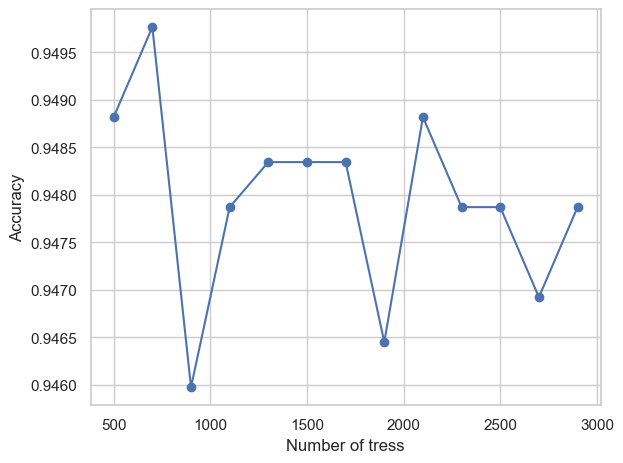

In [ ]:
plt.plot(rf_estimators, epoch_list_score, marker = 'o')
plt.xlabel('Number of tress')
plt.ylabel('Accuracy')
plt.tight_layout()